<h1 style="color:rgb(0,120,170)">Estimation Theory, Fisher Information, CRLB</h1>

This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

Let us start with some preliminary facts and intuition on why it is often a good idea to use the logarithm in optimization tasks, like parameter estimation:

* log is strictly monotonically increasing, so log likelihood is a strictly monotonically increasing transformation of likelihood and maxima occur at same parameter values
    * $p(x;\theta_1) > p(x;\theta_2) \Leftrightarrow \ln p(x;\theta_1) > \ln p(x;\theta_2)$
    * ${arg\,max}_\theta\ p(x;\theta) = {arg\,max}_\theta \ln p(x;\theta)$    
* products become sums
    * $L = p_1 p_2 p_3$
    * $\ln(L) = \ln(p_1) + \ln(p_2) + \ln(p_3)$
* derivatives are easier
    * $\frac{\partial L}{\partial \theta} = 
    \frac{\partial p_1}{\partial \theta} p_2 p_3 +
    p_1 \frac{\partial p_2}{\partial \theta} p_3 +
    p_1 p_2 \frac{\partial p_3}{\partial \theta}
    $
    * $\frac{\partial \ln(L)}{\partial \theta} = 
    \frac{\partial \ln(p_1)}{\partial \theta} +
    \frac{\partial \ln(p_2)}{\partial \theta} + 
    \frac{\partial \ln(p_3)}{\partial \theta}$
* likelihoods become very small and consequently they run out of floating point precision very quickly
    * log likelihoods are numerically more stable
* for some distributions the log space avoids expansive computation
    * exp in gaussian pdf:
        * $p(x; \theta) = \frac{1}{(\sqrt{2\pi})^{d}\sqrt{det \Sigma}}\exp^{-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)}$
    * no exp in log space:
        * $\ln p(x; \theta) = -\frac{d}{2}\ln(2\pi) -\frac{1}{2}\ln(det \Sigma) - \frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)$

Let us also briefly visualize the situation with a plot of the log-likelihood vs. the actual likelihood. You should see that the logarithm is just a monotonic transform, so it doesn't change the actual optimization problem at hand.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

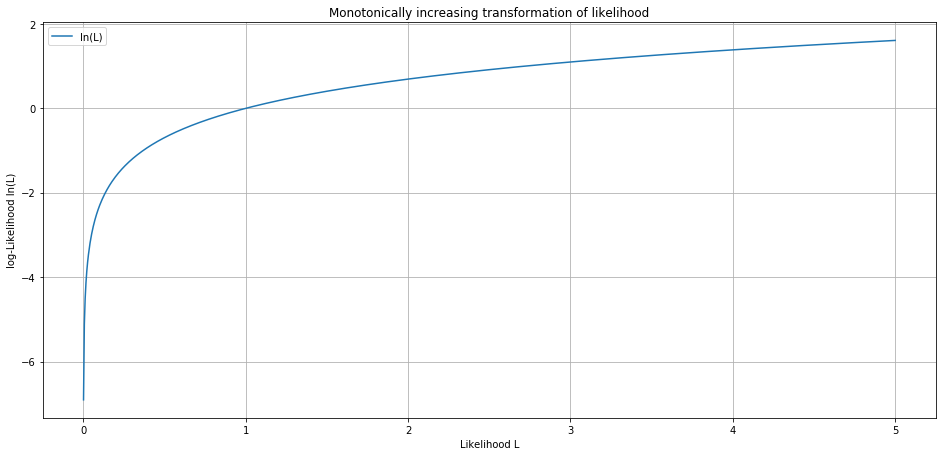

In [2]:
# plot of likelihood vs. log-likelihood

L = np.linspace(0.001,5,1000)
L_ln = np.log(L)
L_log2 = np.log2(L)
L_log10 = np.log10(L)

fig = plt.figure(figsize=(16,16))
plt.subplot(2,1,1)
plt.plot(L, L_ln, label='ln(L)')
plt.xlabel('Likelihood L')
plt.ylabel('log-Likelihood ln(L)')
plt.grid()
plt.legend()
plt.title("Monotonically increasing transformation of likelihood");

<h2 style="color:rgb(0,120,170)">Task 1: On the Fisher Information of Gaussians</h2>

Consider a sequence of independent and identically distributed (i.i.d.) random variables $x_{1}, x_{2},...,x_{n}$ that are sampled from a normal distribution with an unknown expectation parameter $\mu$ and a known standard deviation parameter $\sigma$, i.e.
$x_{i}$ are distributed according to the density function

$$
p(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\, \text{exp}^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}
$$

Let us start this task by creating 3 normally distributed datasets with same $\mu = 5$ but different $\sigma = 1,2,4$.
We also want to visualize their histograms and compare with the actual densities. The procedure should be clearly visible from the code below.

In [3]:
def gauss_function(x, mu, sigma):
    """ This is the 1D gaussian probability density function with mean mu and standard deviation sigma """
    
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

In [4]:
def generate_data(mu, sigma, samples):
    """ This funtion generates the data """
    
    x = np.linspace(-5,15,samples)
    
    # get density over x
    density = gauss_function(x, mu, sigma)
    
    # sample for the gaussian distribution
    X_samples = sigma*np.random.randn(n) + mu
    
    return x, density, X_samples

In [5]:
# here we generate 3 datasets with same mu = 5 but different sigmas = 1,2,4

n = 100
mu = 5.0

sigma_1 = 1.0
x, p1, X1 = generate_data(mu, sigma_1, samples=n)

sigma_2 = 2.0
_, p2, X2 = generate_data(mu, sigma_2, samples=n)

sigma_3 = 4.0
_, p3, X3 = generate_data(mu, sigma_3, samples=n)

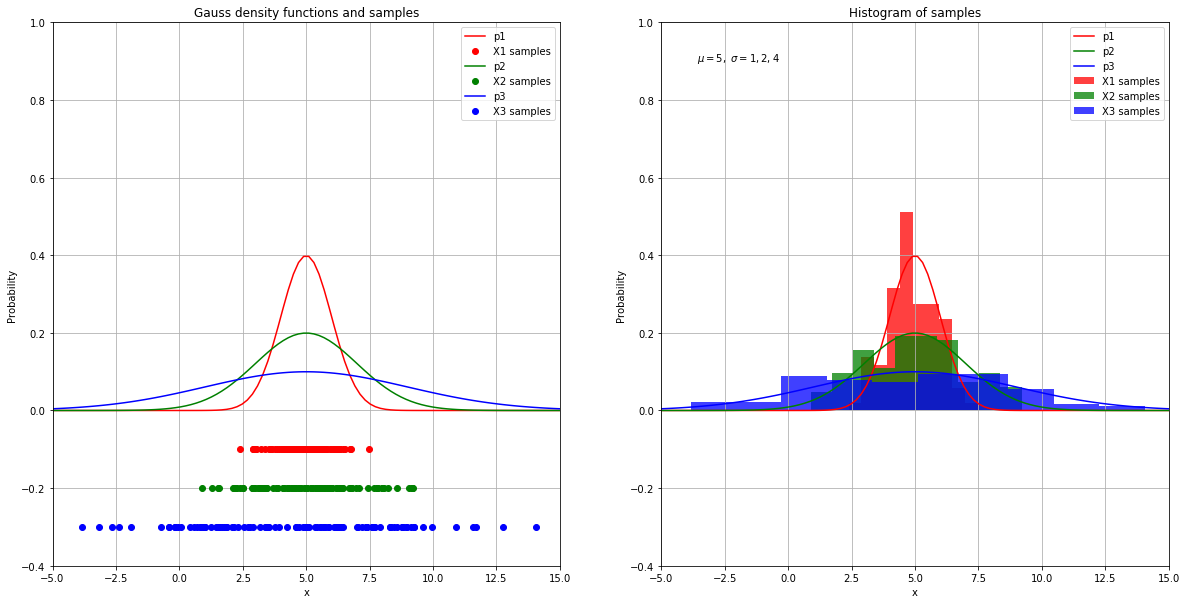

In [6]:
# this code is only for plotting

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(x, p1, label='p1', color='r')
plt.plot(X1, np.repeat(-0.1, len(x)), 'ro', label='X1 samples')
plt.plot(x, p2, label='p2', color='g')
plt.plot(X2, np.repeat(-0.2, len(x)), 'go', label='X2 samples')
plt.plot(x, p3, label='p3', color='b')
plt.plot(X3, np.repeat(-0.3, len(x)), 'bo', label='X3 samples')
plt.axis([-5, 15, -0.4, 1.0])
plt.grid()
plt.title('Gauss density functions and samples')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()

# the histogram of the data

plt.subplot(1,2,2)
n, bins, patches = plt.hist(X1, density=True, facecolor='r', alpha=0.75, label='X1 samples')
plt.plot(x, p1, label='p1', color='r')
n, bins, patches = plt.hist(X2, density=True, facecolor='g', alpha=0.75, label='X2 samples')
plt.plot(x, p2, label='p2', color='g')
n, bins, patches = plt.hist(X3, density=True, facecolor='b', alpha=0.75, label='X3 samples')
plt.plot(x, p3, label='p3', color='b')
plt.legend()

plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Histogram of samples')
plt.text(-3.6, 0.9, r'$\mu=5,\ \sigma=1,2,4$')
plt.axis([-5, 15, -0.4, 1.0])
plt.grid(True)
plt.show()

Next we want to work with the likelihood and log-likelihood of the previously created data. To this end, recall the following definitions:

**Likelihood:**
$$\mathcal{L}(w) = \prod_{i=1}^n p(x_i ; w)$$

**Log-Likelihood:**
$$\ln\mathcal{L}(w) = \sum_{i=1}^n \ln p(x_i ; w)$$

<h3 style="color:rgb(0,120,170)">Task:</h3>

* As a first task, implement the log-likelihood function for a given dataset, a given $\mu$ and a given $\sigma$, using the previously implemented functions. Test your function by executing the print commands below.

<h3 style="color:rgb(208,90,80)">Code (10 points)</h3>

In [7]:
# Calculate the log-likehood function; it should return a scalar value

def log_likelihood(data, mu, sigma):
    """ Calculates the log likelihood"""
    
    ######################################################################
    # Begin To Do: Implement the log_likelihood
    
    gauss_vals = gauss_function(data, mu, sigma)
    
    lnl_pdf_vals = np.log(gauss_vals)
    lnL = lnl_pdf_vals.sum()

    # End To Do
    ######################################################################
        
    return lnL

In [8]:
print("ln L(X1,mu=5,sigma1) = %8.2f" % log_likelihood(X1, mu=5, sigma=sigma_1))
print("ln L(X1,mu=5,sigma2) = %8.2f" % log_likelihood(X1, mu=5, sigma=sigma_2))
print("ln L(X1,mu=5,sigma3) = %8.2f" % log_likelihood(X1, mu=5, sigma=sigma_3))
print("\n")
print("ln L(X2,mu=5,sigma1) = %8.2f" % log_likelihood(X2, mu=5, sigma=sigma_1))
print("ln L(X2,mu=5,sigma2) = %8.2f" % log_likelihood(X2, mu=5, sigma=sigma_2))
print("ln L(X2,mu=5,sigma3) = %8.2f" % log_likelihood(X2, mu=5, sigma=sigma_3))
print("\n")
print("ln L(X3,mu=5,sigma1) = %8.2f" % log_likelihood(X3, mu=5, sigma=sigma_1))
print("ln L(X3,mu=5,sigma2) = %8.2f" % log_likelihood(X3, mu=5, sigma=sigma_2))
print("ln L(X3,mu=5,sigma3) = %8.2f" % log_likelihood(X3, mu=5, sigma=sigma_3))

ln L(X1,mu=5,sigma1) =  -140.67
ln L(X1,mu=5,sigma2) =  -173.40
ln L(X1,mu=5,sigma3) =  -233.57


ln L(X2,mu=5,sigma1) =  -280.20
ln L(X2,mu=5,sigma2) =  -208.29
ln L(X2,mu=5,sigma3) =  -242.29


ln L(X3,mu=5,sigma1) =  -800.46
ln L(X3,mu=5,sigma2) =  -338.35
ln L(X3,mu=5,sigma3) =  -274.81


Now let us gain some intuition on how the log-likelihood function behaves, if data and $\sigma$ are given, but $\mu$ varies in the set $[-5,15]$. 
* Your task is to complete the implementation of the function calculate_log_likelihood_over_mu so that it outputs the list mu_set (which has already been created) and an array lnl_array, containing the resulting log-likelihoods. Afterward, execute the plotting routine to the different values of $\sigma$.

<h3 style="color:rgb(208,90,80)">Code (20 points)</h3>

In [9]:
def calculate_log_likelihood_over_mu(data, sigma):
    
    mu_set = np.linspace(-5,15,501)
    lnL_list = []

    ######################################################################
    # Begin To Do
    
    mu_set_list = list(mu_set)
    
    for i in mu_set_list:
        
        new_lnl_val = log_likelihood(data, i, sigma)
        
        lnL_list.append(new_lnl_val)

    

    # End To Do
    ######################################################################
    
    lnL_array = np.array(lnL_list)
    return mu_set, lnL_array

In [10]:
mu_set, lnL_array1 = calculate_log_likelihood_over_mu(X1, sigma_1)
_, lnL_array2 = calculate_log_likelihood_over_mu(X2, sigma_2)
_, lnL_array3 = calculate_log_likelihood_over_mu(X3, sigma_3)

In [11]:
print("argmax_mu(lnL(X1,mu,sigma1)): %4.2f" % mu_set[np.argmax(lnL_array1)])
print("argmax_mu(lnL(X2,mu,sigma1)): %4.2f" % mu_set[np.argmax(lnL_array2)])
print("argmax_mu(lnL(X3,mu,sigma1)): %4.2f" % mu_set[np.argmax(lnL_array3)])

argmax_mu(lnL(X1,mu,sigma1)): 4.88
argmax_mu(lnL(X2,mu,sigma1)): 5.04
argmax_mu(lnL(X3,mu,sigma1)): 4.64


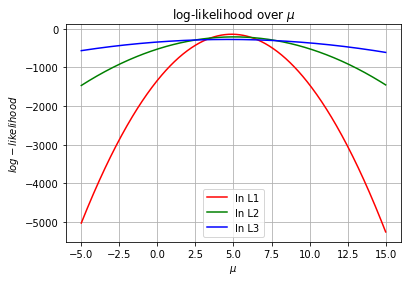

In [12]:
plt.plot(mu_set, lnL_array1, label='ln L1', color='r')
plt.plot(mu_set, lnL_array2, label='ln L2', color='g')
plt.plot(mu_set, lnL_array3, label='ln L3', color='b')
plt.grid()
plt.legend()
plt.title("log-likelihood over $\mu$")
plt.ylabel('$log-likelihood$');
plt.xlabel('$\mu$');

<h3 style="color:rgb(0,120,170)">Task:</h3>

In the previous tasks you should have gained some intuition on how the variance of an unbiased estimator for $\mu$ behaves in certain situations (i.e. for different $\sigma$. Now we want to confirm these observations with a rigorous calculation on the lower bound of this variance:

* Determine/Calculate the Cramer-Rao lower bound for the variance of an unbiased estimator for the parameter $\mu$ for the situation described at the beginning of task 1.


<h3 style="color:rgb(210,90,80)">Calculation (30 points):</h3>

Your calculation here.

By taking a log on the both sides and let $ lnp(x;\mu,\sigma) = l(x;\mu,\sigma) $,

$$ l(x;\mu,\sigma) = - \frac{1}{\sqrt{2\pi\sigma^{2}}} - \frac{1}{2}\ln(2\pi) - \frac{1}{2}\ln(\sigma) $$

Hence, $$ \frac{\partial l}{\partial \sigma}(x;\mu,\sigma) = \frac{(x-u)^2}{2\sigma^2}-\frac{1}{2\sigma} $$

and then, $$ \frac{\partial^2 l}{\partial \sigma^2} = - \frac{(x-u)^2}{\sigma^3}+\frac{1}{2\sigma^2}$$

Therefore, we have

$$ B(\sigma) = -E[\frac{\partial^2 l}{\partial \sigma^2}] = \frac{1}{2\sigma^2} $$

and $$ B_n(\sigma) = nB(\sigma) = \frac{n}{2\sigma^2} $$

The Cramer-Rao lower bound is $ \frac{2\sigma^2}{n} $

<h3 style="color:rgb(0,120,170)">Task:</h3>

* Now you are asked to implement the result of the previous task, i.e. provide a function that outputs the Fisher information for given number $n$ of data and $\sigma$.

<h3 style="color:rgb(208,90,80)">Code (5 points)</h3>

In [13]:
def fisher_information_mu(n, sigma):
    """ Calculate the fisher information  """
    
    ######################################################################
    # Begin To Do: Implement the result from above
    numerator = 2*(sigma**2)
    return n/numerator
    # End To Do
    ######################################################################

In [14]:
print("Fisher Information sigma=1: IF =", fisher_information_mu(n=100, sigma=1))
print("Fisher Information sigma=2: IF =", fisher_information_mu(n=100, sigma=2))
print("Fisher Information sigma=4: IF =", fisher_information_mu(n=100, sigma=4))

Fisher Information sigma=1: IF = 50.0
Fisher Information sigma=2: IF = 12.5
Fisher Information sigma=4: IF = 3.125


<h3 style="color:rgb(208,90,80)">Question (5 points)</h3>

Finally answer some questions on your observations (1-2 sentences are enough):
* How does the variance of the estimator of the mean $\mu$ depend on standard deviation $\sigma$ and sample number $n$?
* Which values of $\sigma$ are better for estimating $\mu$?

** Solution: **
1. According to the equation of Fisher Information, sample number $n$ is directly proportional to the variance of the estimator mean, whereas squared $\sigma$ is inversely proportional to the variance of the estimator.

2. Based on the previous experiment, a lower $\sigma$ provides a higher value of Fisher Information and it means better for estimating $\mu$.

<h2 style="color:rgb(0,120,170)">Task 2: Estimation properties of arithmetic mean</h2>

In this task, we want to prove some easy properties of the arithmetic mean as an estimator for the mean of the sample given in task 1.

* Consider the estimator $\hat\mu = \sum_{i}^{n} \frac{1}{n} x_{i}$ i.e. the aritmetic mean of the observations. Show that this is an unbiased estimator for the parameter $\mu$.

<h3 style="color:rgb(210,90,80)">Calculation (15 points):</h3>

** Solution: **

Suppose that the samples are i.i.d and then its variance can be written as 

$$ var(\hat \mu) = var(\sum \frac{1}{n} x_i) = \frac{1}{n^2} \sum var(\hat \mu) = \frac{n}{n^2}\sigma^2 = \frac{\sigma^2}{n} $$

\
when the number of samples has sufficiently large, the variance goes to zero.  

If the sample variance of the estimator is not unbiased, it can be defined as

$$ var(x) = S^2 = \frac{\sum (x_i - \hat\mu)}{n-1} $$

and the variance of the estimator can be written as 

$$ var(x) = S^2 = \sigma^2 +bias $$

and we can define the estimator is an unbiased estimator if its value of bias has zero. 

\
We want to compute the expectation of the value
\
$$ E[S^2] = E\bigg[\frac{\sum (x_i - \hat\mu)}{n-1}\bigg]$$

$$ E[S^2] = \frac{1}{n-1}E\bigg[\sum^n_{i=1}(x_i - \hat\mu)\bigg] $$
\
Then, we rewrite the previous equation, 

$$ (n-1)E[S^2] = E\bigg[\sum^n_{i=1}x_i^2-2x_i\mu+ \mu^2 \bigg]  $$

$$ (n-1)E[S^2] = E\big[\sum x_i^2\big] - E[\sum 2x_i\mu\big] +E\big[\sum\mu^2]  $$

$$ (n-1)E[S^2] = E\big[\sum x_i^2\big] - E[2\mu (n\hat \mu)] +E\big[\sum\mu^2]  $$

$$ (n-1)E[S^2] = E\big[\sum x_i^2\big] - nE\big[\hat \mu^2 \big]$$

$$ (n-1)E[S^2] = nE\big[x_i^2\big] - nE\big[\hat \mu^2 \big]$$


$$ \frac{(n-1)}{n}E[S^2] = E\big[x_i^2\big] - E\big[\hat \mu^2 \big] \tag{1} $$ 


\
Now, we take into the last term of the previous equeation,
\
$$ E[\hat \mu^2] = var\big[\frac{1}{n}\sum x_i \big] + \mu^2 $$

$$ E[\hat \mu^2] = \frac{1}{n^2}\sum \sigma^2 + \mu^2 $$

$$ E[\hat \mu^2] = \frac{1}{n^2} (n\sigma^2) + \mu^2 $$


$$ E[\hat \mu^2] = \frac{1}{n} \sigma^2 + \mu^2 $$


Let go back to the (1) equation and apply it, 

$$ \frac{(n-1)}{n}E[S^2] = [\sigma^2 + \hat \mu^2]- \big[\frac{1}{n}\sigma^2 + \hat \mu\big]$$


$$ \frac{(n-1)}{n}E[S^2] = \sigma^2 - \frac{1}{n}\sigma^2$$

If n goes to sufficient large samples, then $ n-1= n $ and $\frac{1}{n}\sigma^2$ goes to zero.

$$ E[S^2] = \sigma^2 $$


<h3 style="color:rgb(0,120,170)">Task:</h3>

* Check if the estimator $\hat\mu = \frac{1}{n} \sum_{i}^{n} x_{i}$ is efficient.

<h3 style="color:rgb(210,90,80)">Calculation (15 points):</h3>

** Solution: **

As already shown the estimator is an unbiased, then the variance of this estimator is $ \frac{\sigma^2}{n} $ , as well, from task1, $ B_n(\sigma) = nB(\sigma) = \frac{n}{2\sigma^2} $

As well, $ 0 \le efficiency \le 1 $ and the equation of efficiency can be defined to $ \frac{1/B_n(\sigma)}{Variance\: of\: the\: estimator} $

Hence, the efficiency of the estimator is $$ \frac{\frac{n}{2\sigma^2}}{\frac{\sigma^2}{n}} =  \frac{1}{2}$$